# All code from Raj and Dr. Gutman¶
# minor FG changes

In [1]:
# A multi-class image classifier, based on convolutional neural network using Keras and Tensorflow. 
# 18 classes
# Largely copied from: https://gist.github.com/seixaslipe
# Based on: https://medium.com/alex-attia-blog/the-simpsons-character-recognition-using-keras-d8e1796eae36
# Data downloaded from Kaggle 
# Will emulate the image classification functionlities for Neuro Pathology images/slides (WSI-Whole Slide images)
# Will implement/include data manipulating functionalities based on Girder (https://girder.readthedocs.io/en/latest/)
# Has 6 convolutions, filtering:64, 128, 256 with flattening to 1024
# Keras.ImageDataGenerator for Training/Validation data augmentation
# Environment: Keras, TensorFlow, Python-2, GPU-enabled

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.callbacks import Callback
import datetime, time, os, sys
import numpy as np
import h5py
import matplotlib as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import pandas as pd
from keras.utils import multi_gpu_model

import nvidia_smi as nvs

Using TensorFlow backend.


# Add-in ability to add memory - GPU RAM

In [2]:
### Add in ability to add memory as needed and not preallocate all GPU RAM--will allow parallel models to be run### Add 
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

# Metadata json: GPU

In [3]:
# modelinfo: json to store system metadata:# model 
modelInfo = {}
# GPU/CPU:
modelInfo['Device']  = {}

# initialize GPU to get detailed info:
nvs.nvmlInit()
# Driver version:
driverVersion = nvs.nvmlSystemGetDriverVersion()
# Number of devices:
deviceCount = nvs.nvmlDeviceGetCount()
# Device Names:
deviceNames = []
for i in range(deviceCount):
    handle = nvs.nvmlDeviceGetHandleByIndex(i)
    dvn = nvs.nvmlDeviceGetName(handle) # store the device name
    deviceNames.append(dvn)
    # e.g. will print:
    #  Device 0 : Tesla K40c
nvs.nvmlShutdown()
# Save GPU metadata to modelInfo
modelInfo['Device']['driverVersion']  = driverVersion
modelInfo['Device']['deviceNames']  = deviceNames

# User Input:¶

In [4]:
# Image dimension:
img_width, img_height = 64, 64
# Epochs
epochs = 10
# Batch size:
batch_size = 64

# Save model metadata to modelInfo:
modelInfo['batch_size'] = batch_size
modelInfo['epochs'] = epochs
modelInfo['img_width'] = 64
modelInfo['img_height'] = 64
 

# Training and Validation Images Locations
training_dir = '/data/train'
test_dir = '/data/test'

# Results Location:
results_dir ="/output/results/"

# Basic Image Statistics:¶

In [5]:
# Count training images:
ntraining = 0
for root, dirs, files in os.walk(training_dir):
    ntraining += len(files)

# Getting data format:

In [6]:
# get data format:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

# Data Augmentation:¶

In [7]:
# Training Data Generator with Augmentation:
# -Scale
# -Shear
# -Zoom
# -Height and Width Shift
# -Fill: Nearest
# -Horizontal Flip
train_datagen = ImageDataGenerator(rescale=1./255., shear_range=0.2,zoom_range=0.2, width_shift_range = 0.2,
                          height_shift_range = 0.2,fill_mode = 'nearest',   horizontal_flip=True, validation_split=0.1)

# Validation Data Generator:
# -Scale
val_datagen = ImageDataGenerator(rescale=1. / 255. , validation_split=0.1)


# Training Data flow from directory:
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

# Validation Data flow from directory:
val_generator = val_datagen.flow_from_directory(
    training_dir, 
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

# Number of Classes/Labels:
nLabels = len(val_generator.class_indices)

Found 17102 images belonging to 18 classes.
Found 1890 images belonging to 18 classes.


# Model¶

In [8]:
# Model
# - 6 Convolusional Layers
# - RELU Activation
# 32 -> 64 -> 256 -> 1024
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), padding='same')) 
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nLabels, activation = 'softmax'))

#model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


# Captures GPU usage
#subprocess.Popen("timeout 120 nvidia-smi --query-gpu=utilization.gpu,utilization.memory --format=csv -l 1 | sed s/%//g > /app/results/GPU-stats.log",shell=True)

# Multi-GPU model on training network

In [9]:
# Replicates `model` on 2 GPUs.
# This assumes that your machine has 2 available GPUs.
parallel_model = multi_gpu_model(model, gpus=2)
parallel_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# TimeHistory: Callback class to get timings¶

In [10]:
# Timehistory callback to get epoch run times
class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

# Single GPU Model Run

In [11]:
# Model fitting and training run
#simpsonsModel = model.fit_generator(train_generator, steps_per_epoch= ntraining // batch_size, 
#                                    epochs= epochs, validation_data=val_generator, callbacks= [time_callback])

# print "Training Finished"

# Multi-GPU Model run 

In [12]:
simpsonsModel = parallel_model.fit_generator(train_generator, steps_per_epoch= ntraining // batch_size,
                                             epochs= epochs, validation_data=val_generator, callbacks= [time_callback])

Epoch 1/10
296/296 [==============================] - 162s 546ms/step - loss: 2.5744 - acc: 0.1853 - val_loss: 2.0275 - val_acc: 0.3831
Epoch 2/10
296/296 [==============================] - 192s 648ms/step - loss: 1.7406 - acc: 0.4498 - val_loss: 1.4434 - val_acc: 0.5640
Epoch 3/10
296/296 [==============================] - 180s 608ms/step - loss: 1.2155 - acc: 0.6205 - val_loss: 1.0057 - val_acc: 0.6963
Epoch 4/10
296/296 [==============================] - 177s 599ms/step - loss: 0.9217 - acc: 0.7178 - val_loss: 0.7716 - val_acc: 0.7704
Epoch 5/10
296/296 [==============================] - 173s 584ms/step - loss: 0.7396 - acc: 0.7741 - val_loss: 0.6813 - val_acc: 0.8074
Epoch 6/10
296/296 [==============================] - 183s 617ms/step - loss: 0.6405 - acc: 0.8077 - val_loss: 0.6234 - val_acc: 0.8280
Epoch 7/10
296/296 [==============================] - 186s 628ms/step - loss: 0.6019 - acc: 0.8226 - val_loss: 0.5362 - val_acc: 0.8434
Epoch 8/10
296/296 [============================

In [13]:
! mkdir -p /output/results/

# Save Run metadata to modelInfo¶

In [14]:
# Get timestamp:
now = datetime.datetime.now()
filetime = str(now.year)+str(now.month)+str(now.day)+'_'+str(now.hour)+str(now.minute)

# Time per Epoch:
modelInfo['epochTimeInfo'] = time_callback.times

# Save timestamped model to modelfilename
modelfilename=results_dir+'Simpsonsmodel_'+filetime+'.h5'
model.save(modelfilename)

# Save Run Results to modelInfo:

In [15]:
# Training and Validation accuracy and loss per epoch
modelInfo['historyData'] =  pd.DataFrame(simpsonsModel.history).to_dict(orient='records')

###target_names maps the character names (or labels) to the index(integer) used in the output files
modelInfo['target_names']  = val_generator.class_indices

modelInfo['labelname_to_index']  = val_generator.class_indices
modelInfo['index_to_labelname']  = {(v,k) for k,v in val_generator.class_indices.iteritems() }

# Run Model on Test Images:

In [16]:
# Get number of Testing Images
nTest = 0
for root, dirs, files in os.walk(test_dir):
    nTest += len(files)

In [17]:
# Testing Data Generator:
test_datagen = ImageDataGenerator(rescale=1. /255.)
testing_generator_noShuffle = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical')

Found 890 images belonging to 18 classes.


In [18]:
# predict_Validation: narray
# row= image
# column= probability of falling within label matching column_index
predict_Testing = model.predict_generator(testing_generator_noShuffle)

In [19]:
# Best Prediction for all labels: I don't know why we are calculating this (FG)
best_prediction_per_label= [ max( predict_Testing[:,j] ) for j in range( predict_Testing.shape[1] ) ]

# Predicted label for each image:

In [20]:
predicted_labels= []
# Find highest probability in prediction list for each image
for i in predict_Testing:
    i= list(i)
    max_value = max(i) 
    predicted_labels.append( i.index(max_value) )

# Confusion Matrix generation

In [21]:
modelInfo['confusion_matrix'] = confusion_matrix(testing_generator_noShuffle.classes, predicted_labels)

In [22]:
modelInfo['confusion_matrix']

array([[36,  0,  0,  1,  0,  0,  0, 11,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0],
       [ 0, 47,  0,  2,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
         0,  0],
       [ 0,  0, 44,  0,  0,  0,  0,  0,  0,  0,  4,  1,  0,  0,  0,  0,
         0,  1],
       [ 0,  0,  0, 47,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0],
       [ 0,  0,  0,  2, 45,  0,  0,  0,  0,  0,  0,  1,  0,  2,  0,  0,
         0,  0],
       [ 0,  0,  0,  0,  1, 39,  0,  0,  1,  3,  0,  0,  0,  3,  1,  1,
         0,  0],
       [ 0,  0,  2,  1,  0,  0, 39,  2,  0,  0,  1,  0,  0,  0,  3,  1,
         1,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 49,  0,  0,  1,  0,  0,  0,  0,  0,
         0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  2, 48,  0,  0,  0,  0,  0,  0,  0,
         0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 50,  0,  0,  0,  0,  0,  0,
         0,  0],
       [ 1,  0,  0,  2,  0,  0,  0,  0,  0,  0, 47,  0,  0,  0,  0,  0,
         0,  0],
       [ 0,  0,  0,  

# Confusion Matrix in a Plot

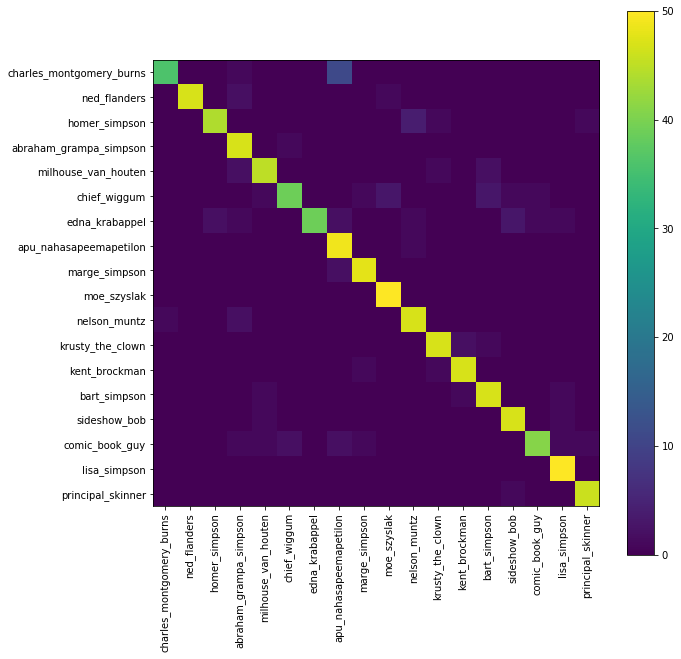

In [33]:
import matplotlib.pyplot as pyplot
pyplot.figure
#target_names = val_generator.class_indices
target_names = testing_generator_noShuffle.class_indices
pyplot.figure(figsize=(10,10))
cnf_matrix = confusion_matrix(testing_generator_noShuffle.classes, predicted_labels)
classes = list(target_names)
pyplot.imshow(cnf_matrix, interpolation='nearest')
pyplot.colorbar()
tick_marks = np.arange(len(classes))  
_ = pyplot.xticks(tick_marks, classes, rotation=90)
_ = pyplot.yticks(tick_marks, classes)
plotopt= results_dir + 'SimpsonsModelImage_'+filetime+'.png'
pyplot.savefig(plotopt)

In [24]:
cls_rpt = classification_report(testing_generator_noShuffle.classes, predicted_labels, target_names= testing_generator_noShuffle.class_indices)

In [25]:
print(cls_rpt)

                          precision    recall  f1-score   support

charles_montgomery_burns       0.97      0.75      0.85        48
            ned_flanders       1.00      0.94      0.97        50
           homer_simpson       0.96      0.88      0.92        50
  abraham_grampa_simpson       0.84      0.98      0.90        48
     milhouse_van_houten       0.92      0.90      0.91        50
            chief_wiggum       0.93      0.80      0.86        49
          edna_krabappel       1.00      0.78      0.88        50
  apu_nahasapeemapetilon       0.74      0.98      0.84        50
           marge_simpson       0.94      0.96      0.95        50
             moe_szyslak       0.93      1.00      0.96        50
            nelson_muntz       0.89      0.94      0.91        50
        krusty_the_clown       0.94      0.94      0.94        50
           kent_brockman       0.94      0.96      0.95        49
            bart_simpson       0.89      0.94      0.91        50
         

# Turning into classification report into classification object

In [26]:
avgresults = cls_rpt.strip().split('\n')[-1].split()

In [27]:
overallResults={'label' : 'avg/total', 'precision': avgresults[3], 'recall':avgresults[4],'f1-score':avgresults[5], 'support':avgresults[6]}

In [28]:
precision, recall, fscore, support  =  precision_recall_fscore_support(testing_generator_noShuffle.classes, predicted_labels)

In [29]:
modelInfo['classificationObject'] =  characterResultsArray =  {
    'label':val_generator.class_indices.keys(),
    'precision': precision,
    'recall':recall,
    'fscore': fscore, 'support':support,
    'overallResults':{'label' : 'avg/total', 
                      'precision': avgresults[3], 
                      'recall':avgresults[4],
                      'f1-score':avgresults[5],
                      'support':avgresults[6]}}

In [30]:
modelInfo['classificationObject']

{'fscore': array([0.84705882, 0.96907216, 0.91666667, 0.90384615, 0.90909091,
        0.85714286, 0.87640449, 0.84482759, 0.95049505, 0.96153846,
        0.91262136, 0.94      , 0.94949495, 0.91262136, 0.93069307,
        0.88172043, 0.96153846, 0.96842105]),
 'label': ['charles_montgomery_burns',
  'ned_flanders',
  'homer_simpson',
  'abraham_grampa_simpson',
  'milhouse_van_houten',
  'chief_wiggum',
  'edna_krabappel',
  'apu_nahasapeemapetilon',
  'marge_simpson',
  'moe_szyslak',
  'nelson_muntz',
  'krusty_the_clown',
  'kent_brockman',
  'bart_simpson',
  'sideshow_bob',
  'comic_book_guy',
  'lisa_simpson',
  'principal_skinner'],
 'overallResults': {'f1-score': u'0.92',
  'label': 'avg/total',
  'precision': u'0.92',
  'recall': u'0.92',
  'support': u'890'},
 'precision': array([0.97297297, 1.        , 0.95652174, 0.83928571, 0.91836735,
        0.92857143, 1.        , 0.74242424, 0.94117647, 0.92592593,
        0.88679245, 0.94      , 0.94      , 0.88679245, 0.90384615,
   

# Create Prediction object for each test image with filename, actual image label, Folder

In [31]:
import glob
import os
import keras.preprocessing.image as Kimg

modelInfo['imgprediction'] = []

model=load_model(modelfilename)

for fld in os.listdir('/data/test/'): 
    trueLabel = fld
    for img in os.listdir('/data/test/%s/' %trueLabel): 
        imgPath = "/data/test/%s/%s" % (fld, img)
        x = Kimg.load_img(imgPath, target_size=(64,64))
        x = Kimg.img_to_array(x)
        x = x.reshape((1,) + x.shape)
        x = x/255.
        pr=model.predict(x)
        curr = {'filename': img, 'actualImageLabel': fld, 'modelprediction':pr} 
        modelInfo['imgprediction'].append(curr) 

/usr/local/lib/python2.7/dist-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [32]:
modelInfo['imgprediction']

[{'actualImageLabel': 'abraham_grampa_simpson',
  'filename': 'abraham_grampa_simpson_0.jpg',
  'modelprediction': array([[9.9965441e-01, 6.4559352e-10, 3.2442540e-07, 7.6107909e-08,
          2.5482280e-10, 5.8077552e-09, 2.4098709e-08, 3.4513784e-04,
          1.6417005e-08, 3.7033550e-09, 6.1347059e-08, 3.4116838e-09,
          1.4620703e-08, 4.9539565e-08, 2.7879417e-09, 8.7417176e-09,
          8.0897040e-09, 3.0532638e-10]], dtype=float32)},
 {'actualImageLabel': 'abraham_grampa_simpson',
  'filename': 'abraham_grampa_simpson_1.jpg',
  'modelprediction': array([[1.9817346e-01, 1.0754294e-03, 1.7381879e-02, 1.0157338e-01,
          3.9904648e-03, 6.2790266e-03, 3.9180566e-04, 4.3655783e-01,
          5.4667029e-03, 1.2320812e-02, 8.8021375e-02, 3.2023399e-03,
          4.4905331e-02, 1.9269366e-02, 6.1206883e-03, 3.3276686e-03,
          4.9386885e-02, 2.5556153e-03]], dtype=float32)},
 {'actualImageLabel': 'abraham_grampa_simpson',
  'filename': 'abraham_grampa_simpson_10.jpg',
 

# Generates Top3 Predicted images for each individual image in the "test folder" only

In [ ]:
from PIL import Image
import matplotlib.pyplot as pyplot
rows = 2
cols = 2
img_width, img_height = 64, 64
pyplot.figure()
pyplot.show()
fig, ax = pyplot.subplots(rows, cols, frameon=False, figsize=(5, 5))
fig.suptitle('Prediction Images', fontsize=10, y = 1.03)
count=0

modelInfo['imgprediction'] = []

model=load_model(modelfilename)

for fld in os.listdir('/data/test/'): 
    trueLabel = fld          
    for imgname in os.listdir('/data/test/%s/' %trueLabel): 
        for i in range(rows):
            for j in range(cols):
                imgPath = "/data/test/%s/%s" % (fld, imgname)                
                img = Image.open(imgPath)
                img = img.resize((img_width, img_height), Image.ANTIALIAS)
                ax[i][j].imshow(img)
                img = img_to_array(img)
                img = img/255.0
                img = img.reshape((1,) + img.shape)
                pr = model.predict(img, batch_size= 1)                
                curr = {'filename': img, 'actualImageLabel': fld, 'modelprediction':pr} 
                modelInfo['imgprediction'].append(curr)                
                # To show image with top 3 predicted images
                pred = pd.DataFrame(np.transpose(np.round(pr, decimals = 3)))
                pred = pred.nlargest(n = 3, columns = 0) 
                pred['char'] = [list(modelInfo['labelname_to_index'].keys())[list(modelInfo['labelname_to_index'].values()).index(x)] for x in pred.index]
                charstr = ''
                for k in range(0,3):
                    if k < 2:
                        charstr = charstr+str(pred.iloc[k,1])+': '+str(pred.iloc[k,0])+'\n'
                    else:
                        charstr = charstr+str(pred.iloc[k,1])+': '+str(pred.iloc[k,0])                
                ec = (0, .8, .1)
                fc = (0, .9, .2)
                count = count + 1
                ax[i][j].text(0, -10, charstr, size=10, rotation=0,
                      ha="left", va="top", 
                      bbox=dict(boxstyle="round", ec=ec, fc=fc, alpha = 0.7))
                pyplot.setp(ax, xticks=[], yticks=[])
                pyplot.tight_layout(rect=[0, 0.14, 1, 0.95])
                pyplot.savefig('/data/code/results/prediction_'+ str(imgname) + '.png')